<a href="https://colab.research.google.com/github/hargurjeet/DeepLearning/blob/main/NLP_Twitter_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter Disaster Tweets - Fake or Not**

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. The following program helps in identifying a tweet programatically if a tweet conveys disaster info or not.

# **Table Of Contents**<a name="top"></a>


---



---


  1. [About the Dataset](#1)
  2. [Data Pre Processing](#2)
  3. [Exploring Data Analysis](#3)
  4. [Natural Language Processing](#4)
  5. [StowWord](#5)
  6. [Training and Validation](#6)
  7. [Results](#7)
  8. [Predictions](#8)
  9. [Summary](#9)
  10. [References](#10)

# <font color="darkslateblue" size=+2.0><b>1: AboutDataset</b></font> <a name="1"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)


I am predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.



# <font color="darkslateblue" size=+2.0><b>2: Data Pre Processing</b></font> <a name="2"></a>


---

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Importing all the required libraries

In [26]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns

Downloading the dataset from Kaggle

In [27]:
# Upload kaggle.jason
# please follow this link incase not aware: https://www.kaggle.com/general/74235
from google.colab import files
files.upload()

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/c/nlp-getting-started/data'
od.download(dataset_url)

Saving kaggle.json to kaggle (2).json
Requirement already up-to-date: opendatasets in /usr/local/lib/python3.7/dist-packages (0.1.13)
nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzipping the files and moving them to Train folder

In [28]:
import zipfile
import os

parent_dir = '/content/nlp-getting-started'
directory = 'Train'

path = os.path.join(parent_dir, directory)
os.mkdir(path)

with zipfile.ZipFile('/content/nlp-getting-started/nlp-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

FileExistsError: ignored

In [32]:
df = pd.read_csv("/content/nlp-getting-started/Train/train.csv")

df.shape

(7613, 5)

Accessing few sample records

In [33]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# <font color="darkslateblue" size=+2.0><b>3: Exploratory Data Analysis</b></font> <a name="3"></a>


---

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

So now we will go trough an exploratory data analysis to get insights from tweets. The aim here is to divide this session into topics so we can explore graphics for each subject.

## <font color="dimgrey" size=+2.0><b>3.1: Labels distribution</b></font>

In [34]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

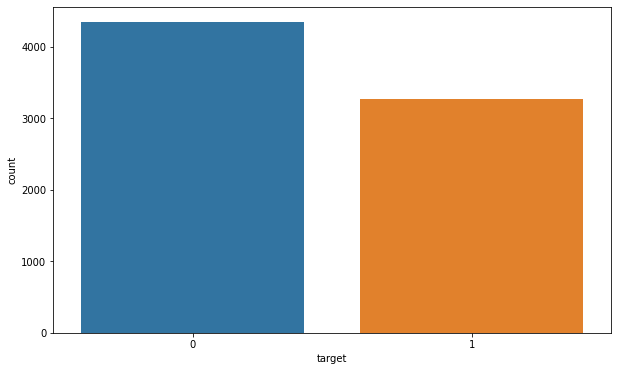

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data = df, x='target')
plt.show()

Labels seems to be evenly distributed

# <font color="darkslateblue" size=+2.0><b>4: Natural Language Processing </b></font> <a name="4"></a>


---

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

## <font color="dimgrey" size=+2.0><b>4.1: Implementing RegEx For 'text' Processing</b></font>

We build a helper function to clean URL and punctuations from the text

In [36]:
import re
import string

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

# https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate/34294022
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Implementing the helper function to the text column

In [37]:
df["text"] = df.text.map(remove_URL) # map(lambda x: remove_URL(x))
df["text"] = df.text.map(remove_punct)

Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

# <font color="darkslateblue" size=+2.0><b>5: StopWord </b></font> <a name="5"></a>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [38]:
# remove stopwords
# pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
df["text"] = df.text.map(remove_stopwords)

In [40]:
df.text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                      m194 0104 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

# <font color="darkslateblue" size=+2.0><b>6: Train and Validation </b></font> <a name="6"></a>


---

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

## <font color="dimgrey" size=+2.0><b>6.1: Train and Split</b></font>

We split the data into training and validation set

In [41]:
# Split dataset into training and validation set
train_size = int(df.shape[0] * 0.8)

train_df = df[:train_size]
val_df = df[train_size:]

# split text and labels

train_sentences = train_df.text
train_labels = train_df.target
val_sentences = val_df.text
val_labels = val_df.target

In [42]:
train_sentences

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
6085            feel like sinking low selfimage take quiz
6086             years afloat pension plans start sinking
6087              feel like sinking unhappiness take quiz
6088    sinking music video tv career brooke hogan tha...
6089    supernovalester feel bad literally feel feelin...
Name: text, Length: 6090, dtype: object

## <font color="dimgrey" size=+2.0><b>6.2: Tokenization</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Word tokenization is the process of splitting a large sample of text into words

In [43]:
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df.text)
num_unique_words = len(counter)

# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

word_index = tokenizer.word_index

#Accessing first few pairs of dictonary
list(word_index.items())[:4]


[('like', 1), ('amp', 2), ('fire', 3), ('im', 4)]

The `test_to_sequences` method covert the sentences into sequeces of numbers

In [44]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

print(train_sentences[10:15])
print(train_sequences[10:15])

10                      three people died heat wave far
11    haha south tampa getting flooded hah wait seco...
12    raining flooding florida tampabay tampa 18 19 ...
13                      flood bago myanmar arrived bago
14        damage school bus 80 multi car crash breaking
Name: text, dtype: object
[[520, 8, 395, 156, 297, 411], [749, 470, 2248, 138, 2249, 2813, 521, 611, 188, 470, 2248, 189, 189, 5679, 117], [2814, 117, 1884, 5680, 2248, 1285, 1450, 522, 256, 644, 2815], [99, 3742, 612, 1451, 3742], [111, 91, 336, 3743, 3744, 52, 22, 312]]


## <font color="dimgrey" size=+2.0><b>6.3: Pad Sequencing</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Since all sentences are not equal hence we must add padding to ensure the symmetry before passing it to the model

In [45]:

# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape

((6090, 20), (1523, 20))

the `truncation` option ensure that any additional words in the sentences above max_length are dropped

In [46]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(train_padded)
training_labels = np.array(train_labels)
testing_padded = np.array(val_padded)
testing_labels = np.array(val_labels)

Before we pass the data to Tensorflow it needs to be converted to numpy array

In [47]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

three people died heat wave far
[520, 8, 395, 156, 297, 411]
[520   8 395 156 297 411   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


## <font color="dimgrey" size=+2.0><b>6.4: Building and Training the Model uisng TensFlow lib</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [48]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_unique_words, 32, input_length=max_length),
    tf.keras.layers.LSTM(64, dropout=0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [49]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            575072    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 599,969
Trainable params: 599,969
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/5
191/191 - 6s - loss: 0.5612 - accuracy: 0.7023 - val_loss: 0.4620 - val_accuracy: 0.7932
Epoch 2/5
191/191 - 3s - loss: 0.2963 - accuracy: 0.8859 - val_loss: 0.5173 - val_accuracy: 0.7846
Epoch 3/5
191/191 - 3s - loss: 0.1653 - accuracy: 0.9429 - val_loss: 0.6562 - val_accuracy: 0.7656
Epoch 4/5
191/191 - 3s - loss: 0.1124 - accuracy: 0.9654 - val_loss: 0.6617 - val_accuracy: 0.7577
Epoch 5/5
191/191 - 3s - loss: 0.0901 - accuracy: 0.9732 - val_loss: 0.6867 - val_accuracy: 0.7492


# <font color="darkslateblue" size=+2.0><b>7: Results </b></font> <a name="7"></a>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

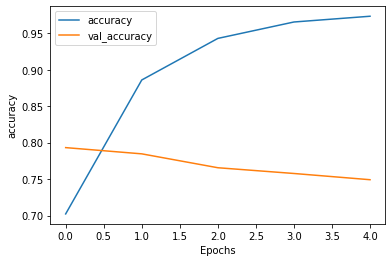

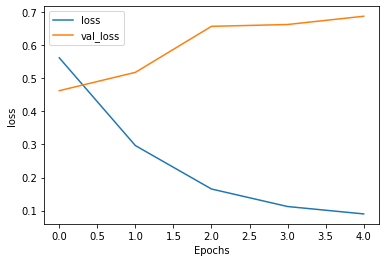

In [51]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Although we are able to achieve good accuracy but it is clearly evidnet the model is over fitting the data

# <font color="darkslateblue" size=+2.0><b>8: Predictions </b></font> <a name="8"></a>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [52]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(train_padded[2]))
print(train_sentences[2])
print(train_labels[2])

residents asked shelter place notified officers evacuation shelter place orders expected ? ? ? ? ? ? ? ? ?
residents asked shelter place notified officers evacuation shelter place orders expected
1


In [54]:
predictions = model.predict(train_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

In [56]:
print(train_sentences[10:20])
print()
print('actual labels')
print(train_labels[10:20])
print('predicted labels')
print()
print(predictions[10:20])

10                      three people died heat wave far
11    haha south tampa getting flooded hah wait seco...
12    raining flooding florida tampabay tampa 18 19 ...
13                      flood bago myanmar arrived bago
14        damage school bus 80 multi car crash breaking
15                                            whats man
16                                          love fruits
17                                        summer lovely
18                                             car fast
19                                      goooooooaaaaaal
Name: text, dtype: object

actual labels
10    1
11    1
12    1
13    1
14    1
15    0
16    0
17    0
18    0
19    0
Name: target, dtype: int64
predicted labels

[1, 1, 1, 1, 1, 0, 0, 0, 1, 0]


# <font color="darkslateblue" size=+2.0><b>9: Summary </b></font> <a name="9"></a>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

- We downloaded Twitter disaster dataset from Kaggle
- We ran the data pre processing and EDA.
- Implemented regular expression to filter out the processing data.
- Implemented stopword
- We trained the model after applying tokenization and Pad sequence
- Results are evluated and conclude the model is overfitting

# <font color="darkslateblue" size=+2.0><b>10: References </b></font> <a name="10"></a>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

- https://www.python-engineer.com/posts/regular-expressions/
- https://www.tensorflow.org/
- https://www.youtube.com/watch?v=fNxaJsNG3-s&ab_channel=TensorFlow
- https://www.youtube.com/watch?v=A9QVYOBjZdY&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=5&ab_channel=TensorFlowTensorFlowVerified